<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [4]:
pip install pygeohash

  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6153 sha256=37c0fbc9fb7b68c0251f3c57252ed4292984aa1ba0a7f919acf8be1000a82ef9
  Stored in directory: /root/.cache/pip/wheels/28/ec/b6/beadf7295a623f528507691fb0d471b50d064ae9bbad420b8f
Successfully built pygeohash


In [5]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [8]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [9]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [10]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


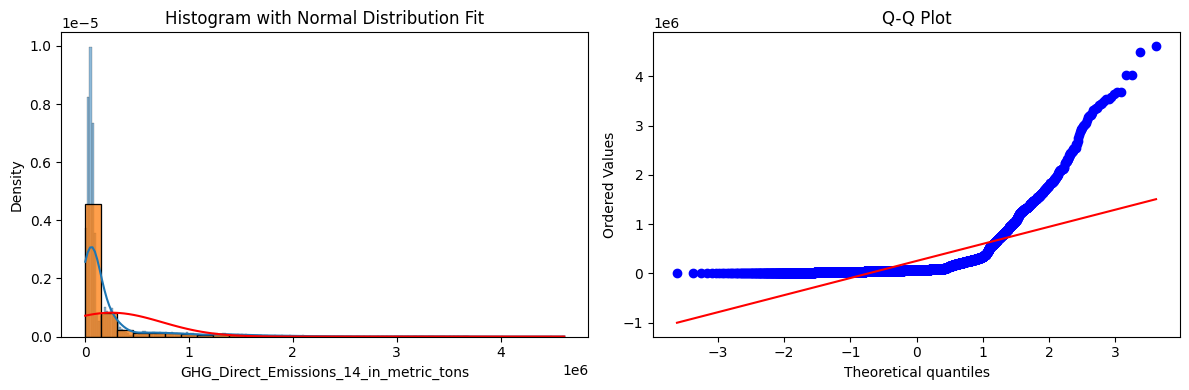

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [11]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

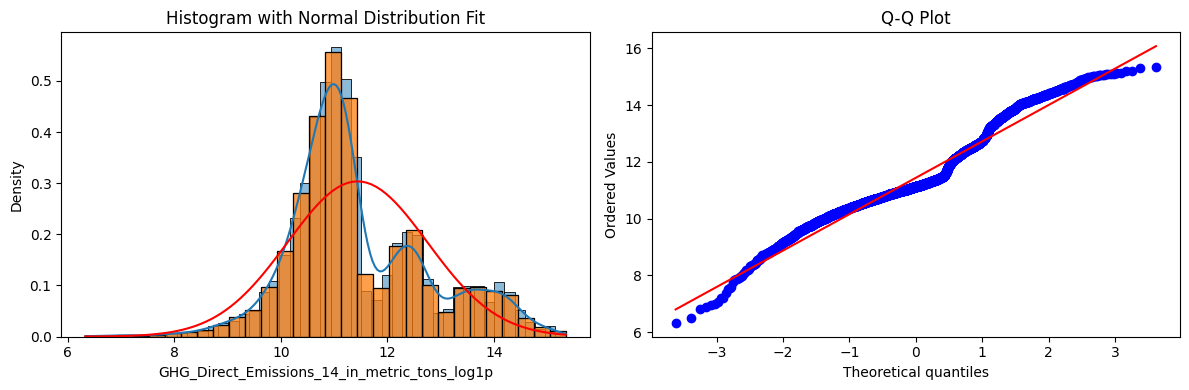

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [12]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [13]:
information_df(test_df)

(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [14]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [15]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# GHGの特徴量

In [16]:
df['GHG_10_log1p'] = np.log1p(df['GHG_Direct_Emissions_10_in_metric_tons'])
df['GHG_11_log1p'] = np.log1p(df['GHG_Direct_Emissions_11_in_metric_tons'])
df['GHG_12_log1p'] = np.log1p(df['GHG_Direct_Emissions_12_in_metric_tons'])
df['GHG_13_log1p'] = np.log1p(df['GHG_Direct_Emissions_13_in_metric_tons'])

# TRIにかかわる特徴量

In [17]:
# TRIの差の特徴量
df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

# TRIの変化率の特徴量
df['TRI_Growth_Rate_11'] = np.where(
    df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
    (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
    np.nan
)

df['TRI_Growth_Rate_12'] = np.where(
    df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
    (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
    np.nan
)

df['TRI_Growth_Rate_13'] = np.where(
    df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
    (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
    np.nan
)

# 直近トレンドをエンコーディング
df['trend_TRI_13_12'] = np.where(df['TRI_diff_13-12'] > 0, 1, 0)
df['trend_TRI_13_11'] = np.where((df['TRI_diff_13-12'] > 0) & (df['TRI_diff_12-11'] > 0), 1, 0)

In [18]:
df['TRI_10_log1p'] = np.log1p(df['TRI_Air_Emissions_10_in_lbs'])
df['TRI_11_log1p'] = np.log1p(df['TRI_Air_Emissions_11_in_lbs'])
df['TRI_12_log1p'] = np.log1p(df['TRI_Air_Emissions_12_in_lbs'])
df['TRI_13_log1p'] = np.log1p(df['TRI_Air_Emissions_13_in_lbs'])

df['TRI_diff_11-10_log1p'] = np.log1p(df['TRI_diff_11-10'])
df['TRI_diff_12-11_log1p'] = np.log1p(df['TRI_diff_12-11'])
df['TRI_diff_13-12_log1p'] = np.log1p(df['TRI_diff_13-12'])

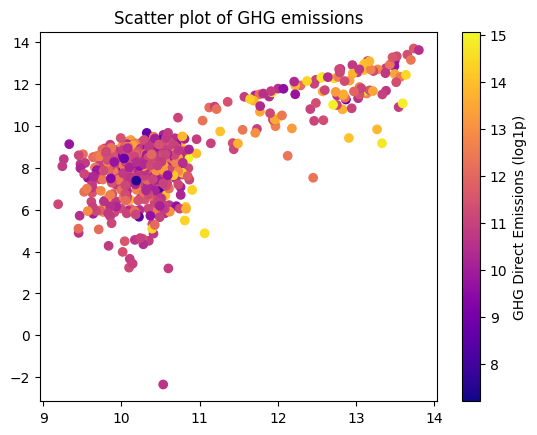

In [19]:
# 散布図を描画
scatter = plt.scatter(x=df['TRI_13_log1p'], y=df['TRI_diff_13-12_log1p'],
                      c=df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')
plt.title('Scatter plot of GHG emissions')
plt.show()

In [20]:
# GHG/TRIの特徴量
df['GHG_TRI_rate_10'] = np.where(
    df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
    df['GHG_Direct_Emissions_10_in_metric_tons'] / df['TRI_Air_Emissions_10_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_11'] = np.where(
    df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
    df['GHG_Direct_Emissions_11_in_metric_tons'] / df['TRI_Air_Emissions_11_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_12'] = np.where(
    df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
    df['GHG_Direct_Emissions_12_in_metric_tons'] / df['TRI_Air_Emissions_12_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_13'] = np.where(
    df['TRI_Air_Emissions_13_in_lbs'].notna() & (df['TRI_Air_Emissions_13_in_lbs'] != 0),
    df['GHG_Direct_Emissions_13_in_metric_tons'] / df['TRI_Air_Emissions_13_in_lbs'],
    np.nan
)


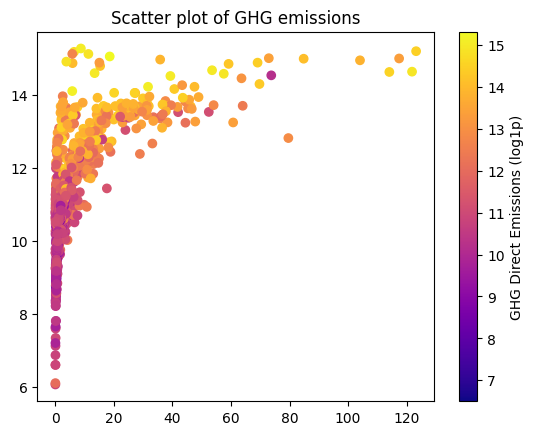

In [21]:
# 散布図を描画
scatter = plt.scatter(x=df['GHG_TRI_rate_13'], y=df['GHG_13_log1p'],
                      c=df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')
plt.title('Scatter plot of GHG emissions')
plt.show()

# Locationにかかわる特徴量

In [22]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

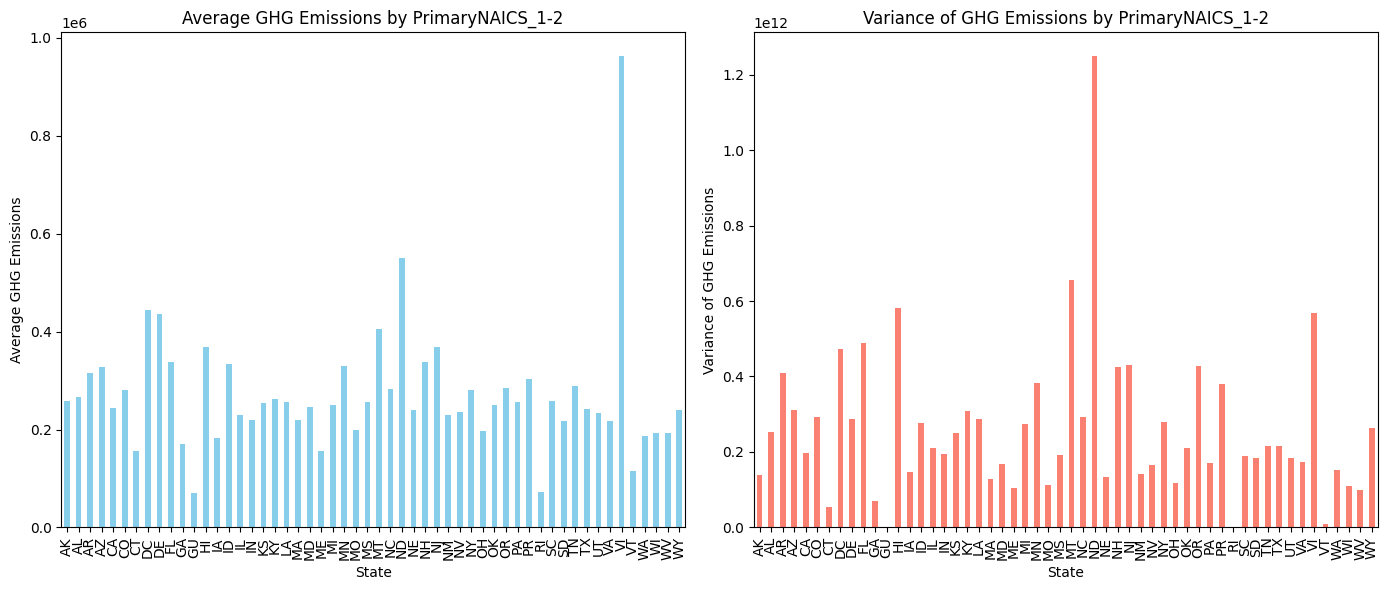

In [23]:
# Stateの特徴量
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

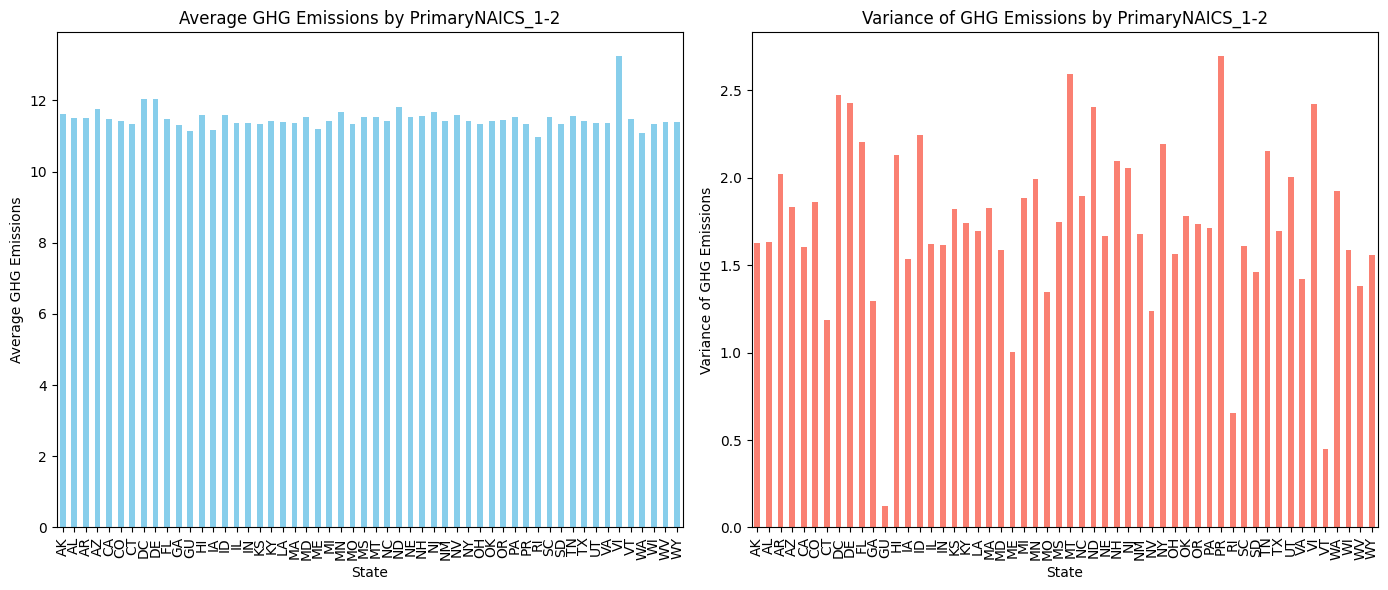

In [24]:
# Stateの特徴量
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

In [25]:
# ターゲットエンコーディング（State）

# Stateごとの平均、分散、変動係数の計算
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])
grouped['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
grouped['cv'] = grouped['std'] / grouped['mean']  # 変動係数

# dfにターゲットエンコーディングを適用
df = df.merge(grouped[['mean', 'var', 'cv']], on='State', how='left')
df.rename(columns={'mean': 'State_GHG_mean', 'var': 'State_GHG_var', 'cv': 'State_GHG_cv'}, inplace=True)

# Stateごとの平均、分散、変動係数の計算
grouped_log1p = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])
grouped_log1p['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
grouped_log1p['cv'] = grouped['std'] / grouped['mean']  # 変動係数

# dfにターゲットエンコーディングを適用
df = df.merge(grouped_log1p[['mean', 'var', 'cv']], on='State', how='left')
df.rename(columns={'mean': 'State_GHG_mean_log1p', 'var': 'State_GHG_var_log1p', 'cv': 'State_GHG_cv_log1p'}, inplace=True)

# df.columns.tolist()

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [26]:
# PrimaryNAICSの最初の２文字の分類
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

# PrimaryNAICSを文字数ごとに分割
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# SecondPrimaryNAICSを分類してカテゴリ変数へ変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

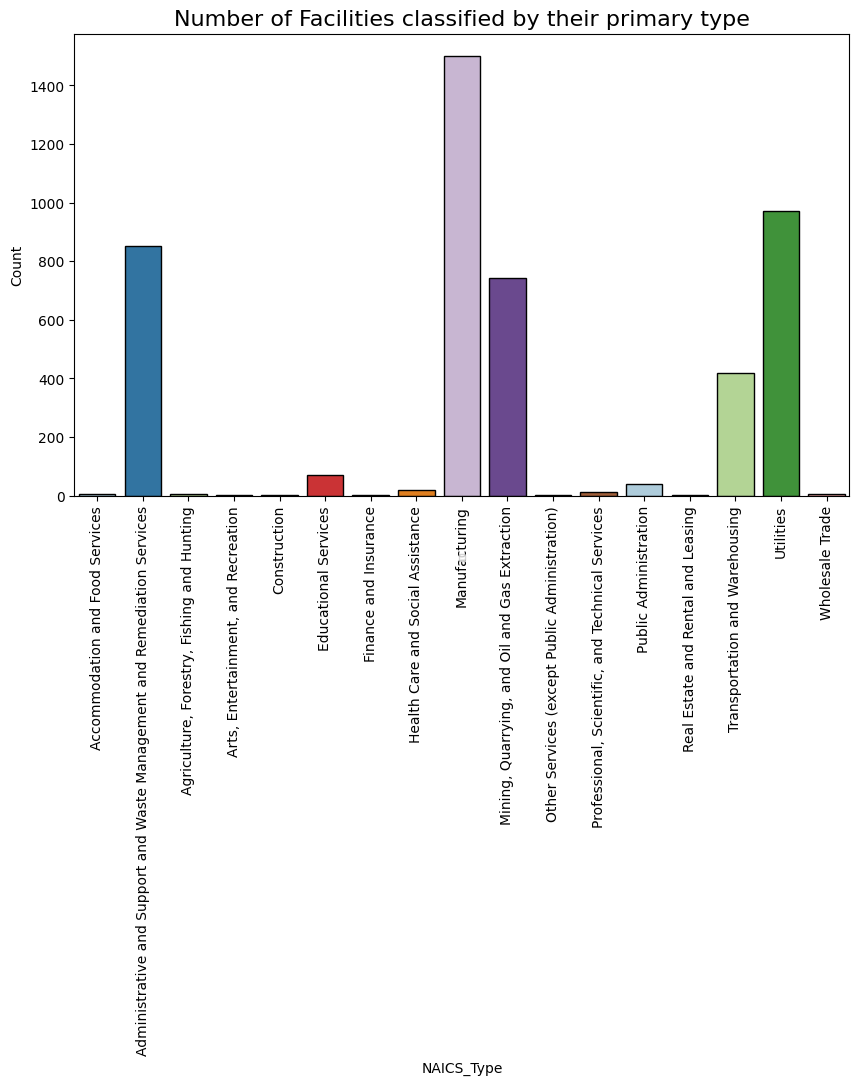

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# データの集計
df_summary = train_df.groupby('NAICS_Type').size().reset_index(name='count')
df_summary = df_summary.sort_values('count', ascending=False)

# カラーパレットの設定
colors = sns.color_palette("Paired", n_colors=20)

# プロットの作成
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_summary,
    x='NAICS_Type',
    y='count',
    palette=colors,
    edgecolor='black'
)

# Y軸を対数スケールに設定
# plt.yscale('log')

# タイトルとラベルの設定
plt.title('Number of Facilities classified by their primary type', fontsize=16)
plt.xlabel('NAICS_Type')
plt.ylabel('Count')

# 軸と凡例の設定
plt.xticks(rotation=90)  # x軸のラベルを回転して表示
plt.legend(
    title='',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    fontsize=6
)

# グラフの表示
plt.tight_layout()
plt.show()


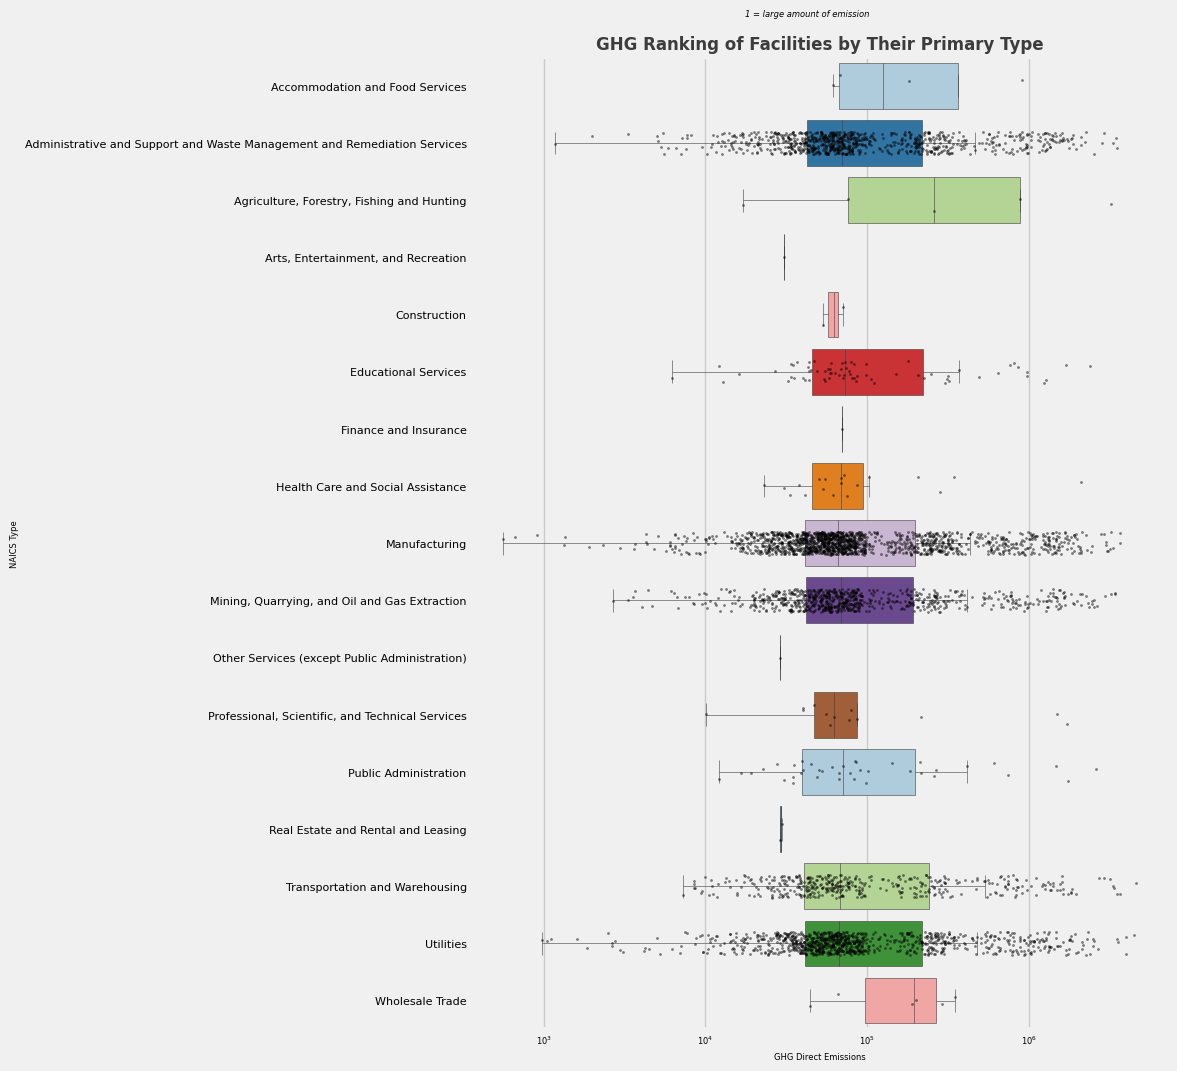

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Assuming df is already loaded as a pandas DataFrame
ghg_df = train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons']]

# Set the style to replicate theme_fivethirtyeight
plt.style.use('fivethirtyeight')

# Create color palette
palette = sns.color_palette("Paired", n_colors=20)

# Set up the figure
plt.figure(figsize=(8, 12))

# Create the boxplot with jitter
sns.boxplot(
    y='NAICS_Type',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    data=ghg_df,
    palette=palette,
    linewidth=0.4,
    fliersize=0,
    whis=1.5
)
sns.stripplot(
    y='NAICS_Type',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    data=ghg_df,
    color='black',
    size=2,
    jitter=0.2,
    alpha=0.5
)

# Set titles and labels
plt.title("GHG Ranking of Facilities by Their Primary Type", fontsize=12, fontweight='bold', color="#3C3C3C")
plt.suptitle("1 = large amount of emission", fontsize=6, style='italic', y=0.92)

# Hide legend
plt.legend([], [], frameon=False)

# Adjust layout
plt.tight_layout()

# Y軸を対数スケールに設定
plt.xscale('log')

# Show the plot
plt.xlabel('GHG Direct Emissions', fontsize=6)
plt.ylabel('NAICS Type', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=8)

plt.show()


In [29]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('GHG_Direct_Emissions_14_in_metric_tons', 'size'), meanTri=('GHG_Direct_Emissions_14_in_metric_tons', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
8,Manufacturing,1502,242241.779348
15,Utilities,973,249955.050176
1,Administrative and Support and Waste Managemen...,853,250811.821049
9,"Mining, Quarrying, and Oil and Gas Extraction",744,252928.100287
14,Transportation and Warehousing,420,293777.481256
5,Educational Services,70,251472.609850
12,Public Administration,39,265045.537769
7,Health Care and Social Assistance,19,199722.193130
11,"Professional, Scientific, and Technical Services",13,306494.681102
16,Wholesale Trade,6,189978.439316


データ数の多い５つのグループは若干の平均には違いはあるものの、データの分布数は全体と変わらないように見受けられる。

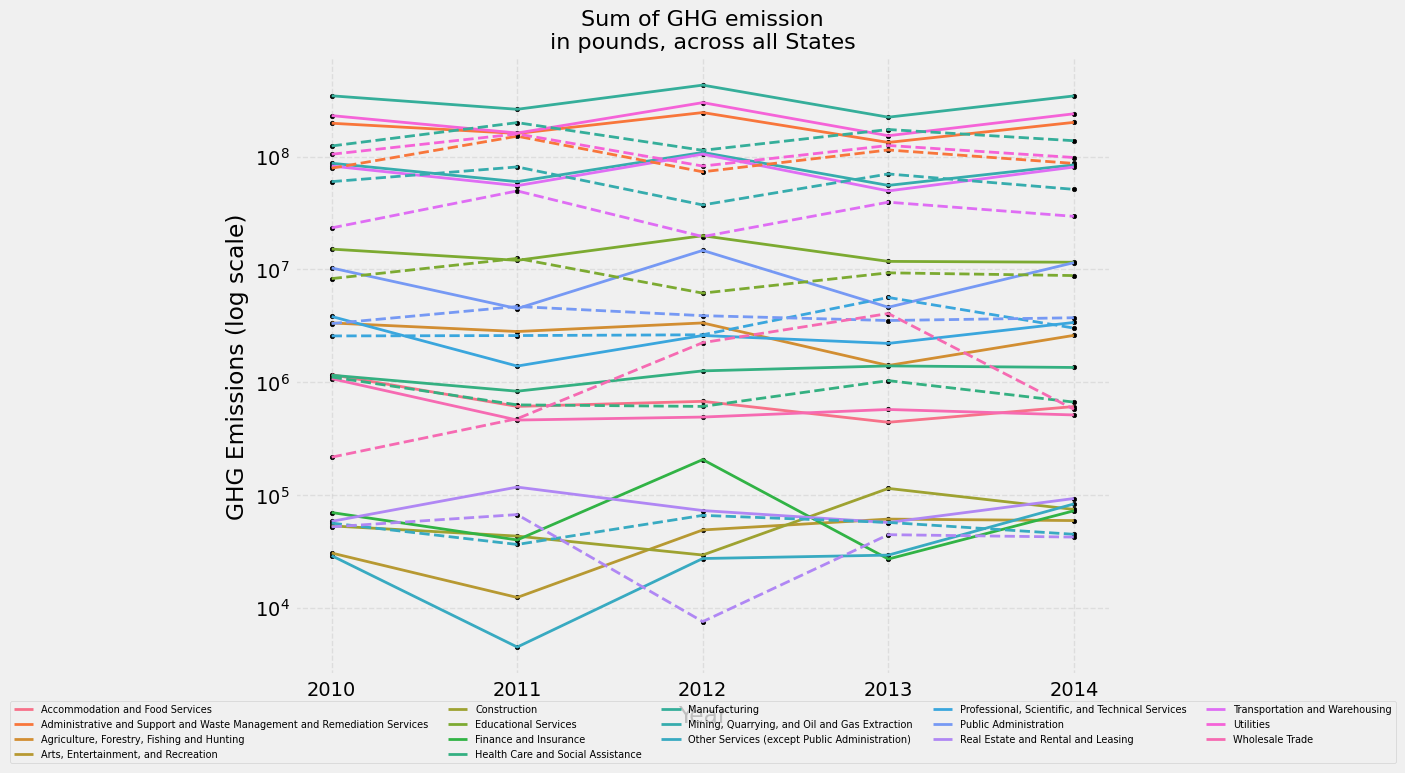

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG.direct.emissions.10': 'sum.GHG.10',
                     'GHG.direct.emissions.11': 'sum.GHG.11',
                     'GHG.direct.emissions.12': 'sum.GHG.12',
                     'GHG.direct.emissions.13': 'sum.GHG.13',
                     'GHG.direct.emissions.14': 'sum.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')
# ベストの予測結果を反映
# submitのインデックスをリセットし、1列目（元インデックス）を削除
test_pred = submit.reset_index(drop=True)

# test_predにカラム名を 'pred' として設定
test_pred.columns = ['id','pred']

# test_dfとtest_predを列方向に結合
test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)


# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'sum.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'sum.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'sum.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'sum.GHG.13',
                                          'pred': 'sum.GHG.14', })
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [60]:
test_df_pred.head()

,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,NAICS_Type,SecondPrimaryNAICS_1-2,Sub_NAICS_Type,GHG_diff_13_12,GHG_diff_12_11,GHG_diff_11_10,GHG_from_diff_13_12,GHG_from_diff_12_11,trend_13_12,trend_13_11
0,4655,ROGER AOTSCHEGAROW,38.03304,-97.97317,1910 SOUTH BROADACRES ROAD,HUTCHINSON,KS,67501,RENO,20155.0,...,"Mining, Quarrying, and Oil and Gas Extraction",NaN,"Mining, Quarrying, and Oil and Gas Extraction",3972.196446,-36809.729988,-23148.368919,36937.684361,-3844.242072,1,0
1,4656,EPNG STATION 6543 LORDSBURG,32.31603,-108.60680,NaN,LORDSBURG,NM,88045,HIDALGO,35023.0,...,Transportation and Warehousing,NaN,Transportation and Warehousing,-43257.932141,NaN,NaN,225410.136969,NaN,0,0
2,4657,OWENS-BROCKWAY GLASS CONTAINER INC PLANT 19,41.25150,-78.74244,3831 ROUTE 219,BROCKPORT,PA,15823,JEFFERSON,42065.0,...,Manufacturing,NaN,Manufacturing,4312.340990,28520.006792,-78695.473267,43357.588377,67565.254179,1,1
3,4658,WALDORF CORP (DBA ROCKTENN),44.95966,-93.19341,2250 WABASH AVE,SAINT PAUL,MN,551141895,RAMSEY,27123.0,...,Manufacturing,NaN,Manufacturing,5942.559013,14210.327521,-48952.565179,26147.483999,34415.252508,1,1
4,4659,SOLAR TURBINES INC KEARNY MESA,32.81872,-117.12580,4200 RUFFIN RD MZ T-2,SAN DIEGO,CA,92123,SAN DIEGO,6073.0,...,Manufacturing,NaN,Manufacturing,23928.705110,24655.184333,-69608.410246,87863.954230,88590.433453,1,1


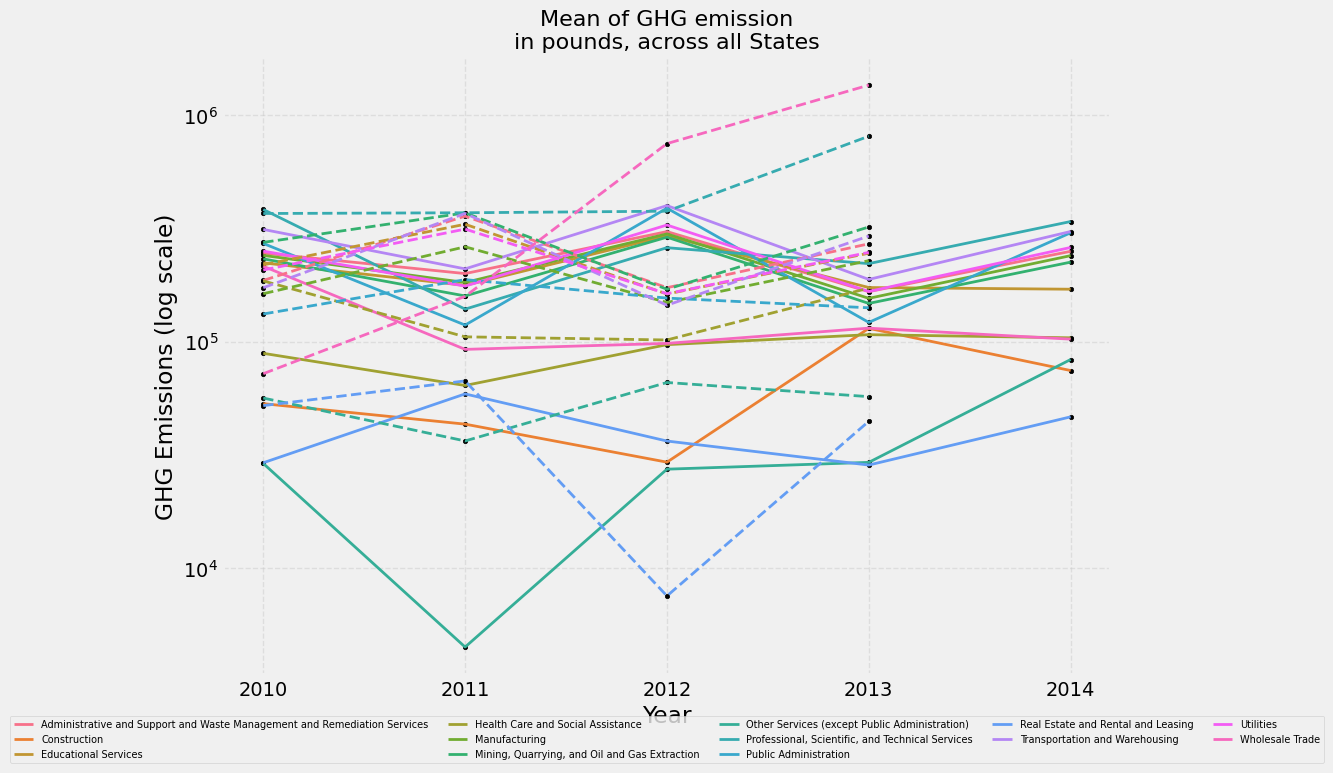

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Data preparation for test GHG_mean
test_ghg_mean = (
    test_df[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13'})
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Filter temp_ghg_melt and temp_merged_ghg_melt to include only NAICS_Type present in test data
valid_naics_types = test_ghg_mean['NAICS_Type'].unique()
temp_ghg_melt = temp_ghg_melt[temp_ghg_melt['primary.industry'].isin(valid_naics_types)]
temp_test_ghg_melt = temp_test_ghg_melt[temp_test_ghg_melt['NAICS_Type'].isin(valid_naics_types)]

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['primary.industry'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions with solid lines (train)
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (test, no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Mean of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


合計値や平均なので一概にはいえないが、上位6つのデータでは、trainデータで2010,2012 vs 2011,2013の構図ができている。単純に戻るを回すと2012や2010が重要度が高い理由になっていると思われる。対して、testデータはtrainデータと真逆の挙動を示しており、trainデータを信頼しすぎると、精度が背反する可能性が高い。

In [32]:
# 各年の差から予測
df['GHG_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']
df['GHG_diff_12_11'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['GHG_diff_11_10'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_from_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_13_12']
df['GHG_from_diff_12_11'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_12_11']

# 直近トレンドをエンコーディング
df['trend_13_12'] = np.where(df['GHG_diff_13_12'] > 0, 1, 0)
df['trend_13_11'] = np.where((df['GHG_diff_13_12'] > 0) & (df['GHG_diff_12_11'] > 0), 1, 0)

In [33]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = train_df[['NAICS_Type', 'TRI_Air_Emissions_13_in_lbs']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('TRI_Air_Emissions_13_in_lbs', 'size'), meanTri=('TRI_Air_Emissions_13_in_lbs', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
8,Manufacturing,1262,54932.424354
15,Utilities,327,63195.604577
9,"Mining, Quarrying, and Oil and Gas Extraction",20,24554.673169
12,Public Administration,18,28348.151346
16,Wholesale Trade,3,34440.297642
1,Administrative and Support and Waste Managemen...,2,206397.851863
11,"Professional, Scientific, and Technical Services",2,15905.041731
14,Transportation and Warehousing,1,32616.566141
5,Educational Services,0,NaN
6,Finance and Insurance,0,NaN


In [34]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = test_df[['NAICS_Type', 'TRI_Air_Emissions_13_in_lbs']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('TRI_Air_Emissions_13_in_lbs', 'size'), meanTri=('TRI_Air_Emissions_13_in_lbs', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
4,Manufacturing,650,47436.901056
11,Utilities,197,61593.783965
5,"Mining, Quarrying, and Oil and Gas Extraction",12,29710.991157
8,Public Administration,7,30170.225615
0,Administrative and Support and Waste Managemen...,4,147963.783117
7,"Professional, Scientific, and Technical Services",3,31248.622434
12,Wholesale Trade,1,352529.159773
1,Construction,0,NaN
2,Educational Services,0,NaN
3,Health Care and Social Assistance,0,NaN


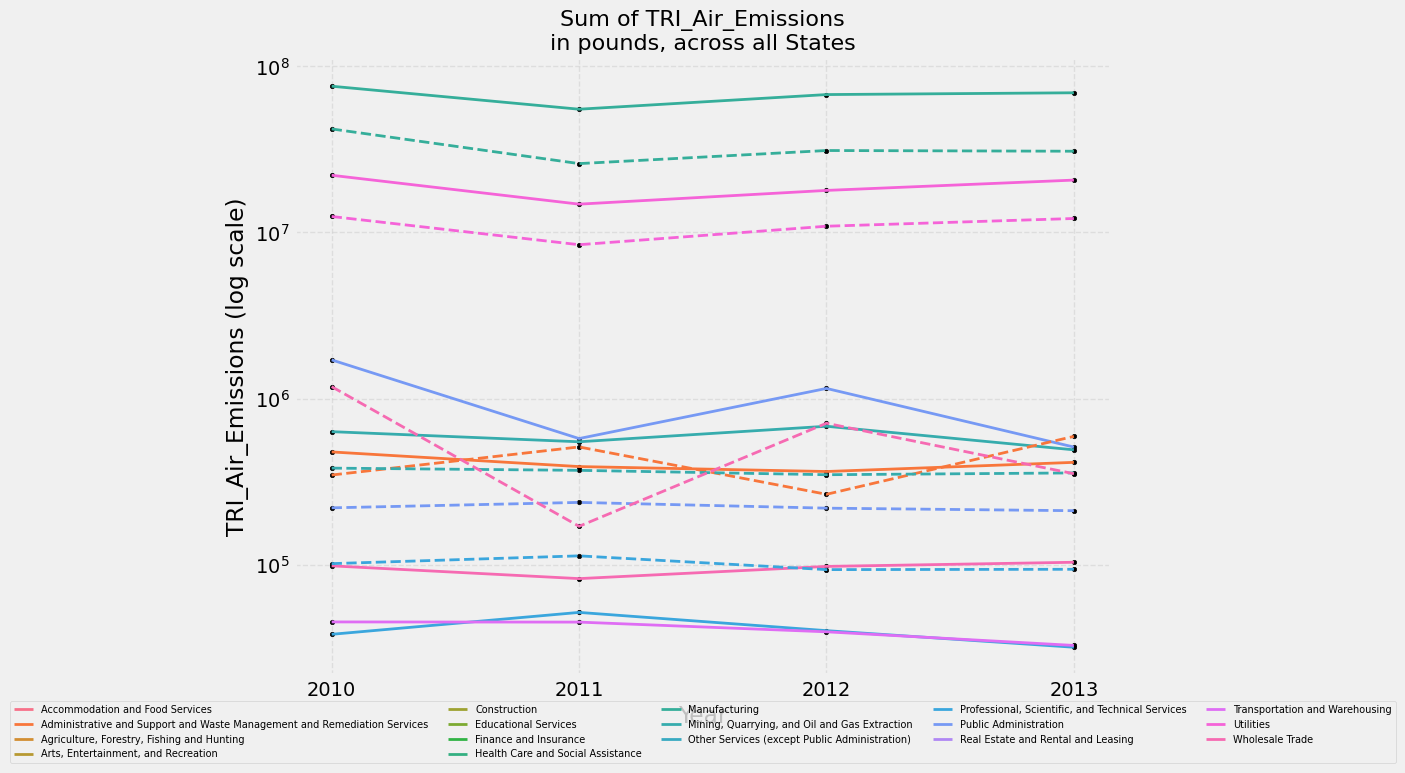

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'TRI_Air_Emissions_10_in_lbs': 'sum.TRI.10',
                     'TRI_Air_Emissions_11_in_lbs': 'sum.TRI.11',
                     'TRI_Air_Emissions_12_in_lbs': 'sum.TRI.12',
                     'TRI_Air_Emissions_13_in_lbs': 'sum.TRI.13',
                    })
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df[['NAICS_Type', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'TRI_Air_Emissions_10_in_lbs': 'sum.TRI.10',
                     'TRI_Air_Emissions_11_in_lbs': 'sum.TRI.11',
                     'TRI_Air_Emissions_12_in_lbs': 'sum.TRI.12',
                     'TRI_Air_Emissions_13_in_lbs': 'sum.TRI.13',})
)


# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of TRI_Air_Emissions\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('TRI_Air_Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


データ数が少なく、十分な特徴量を作成するのが難しそう。上位2つのデータは傾向が似ている。GHGのトレンドとは大きく異なる。


# データインプット

In [36]:
df.columns.tolist()

['Unnamed: 0',
 'FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'is_train',
 'GHG_10_log1p',
 'GHG_11_log1p',
 'GHG_12_log1p',
 'GHG_13_log1p',
 'TRI_diff_11-10',
 'TRI_diff_12-11',
 'TRI_diff_13-12',
 'TRI_Growth_Rate_11',
 'TRI_Growth_Rate_12',
 'TRI_Growth_Rate_13',
 'trend_TRI_13_12',
 'trend_TRI_13_11',
 'TRI_10_log1p',
 'TRI_11_log1p',
 'TRI_12_log1p',
 'TRI_13_log1p',
 'TRI_diff_11-10_log1p',
 'TRI_diff_12-11_log1p',
 'TRI_diff_13-12_log1p',
 'GHG_TRI_rate_10',
 'GHG_TRI_r

In [69]:
features = [
                        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_12-11','TRI_diff_13-12','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
                        # 'GHG_diff_13_12',
#  'GHG_diff_12_11',
#  'GHG_diff_11_10',
#  'GHG_from_diff_13_12',
#  'GHG_from_diff_12_11',
 'trend_13_12',
#  'trend_13_11'
                        #  'trend_TRI_13_12',
#  'trend_TRI_13_11'
]

In [70]:
train_df, test_df = split_train_test(df)

train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

# ハイパラ調整（Optuna）

In [39]:
# pip install optuna

In [40]:
# import optuna
# from sklearn.metrics import mean_squared_log_error
# from lightgbm import LGBMRegressor
# import lightgbm as lgb
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 123
# np.random.seed(123)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target):
#     # Optunaで探索するパラメータ
#     lgbm_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 10, 100),
#         "max_depth": 3,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 10.0),
#         "random_state": 123,
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'verbose': -1,
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
#         "max_bin": trial.suggest_int("max_bin", 150, 200),
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = LGBMRegressor(**lgbm_params)
#         model.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=100)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [41]:
# import optuna
# from sklearn.metrics import root_mean_squared_log_error
# from xgboost import XGBRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 123
# np.random.seed(123)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target):
#     # Optunaで探索するパラメータ
#     xgb_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 300, 700),
#         "max_depth": 4,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
#         "subsample": trial.suggest_float("subsample", 0.6, 0.8),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
#         "random_state": 123,
#         'enable_categorical': True,
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = XGBRegressor(**xgb_params)
#         _ = model.fit(X_train, np.log1p(y_train))

#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
#         rmsle_train = root_mean_squared_log_error(y_train, train_preds)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)



#     return RMSLE


# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=100)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [42]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


# モデルの実行・アンサンブル





In [43]:

# from sklearn.metrics import root_mean_squared_log_error
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# # from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
# import gc
# import numpy as np
# import lightgbm as lgb

# gc.collect()

# def get_models_trained(train, test, target, num_folds):
#     kf = KFold(n_splits=num_folds, shuffle=True, random_state=224)

#     oof_predictions = np.zeros(len(train))
#     test_predictions1 = np.zeros(len(test))
#     train_predictions = np.zeros(len(train))
#     fold_train_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         print(f"------------------------------ fold {fold} ------------------------------")

#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model_dict = {}
#         loss_dict = {}
#         valid_preds_dict = {}
#         train_preds_dict = {}
#         rmsle_dict = {}

#         # モデル1
#         params1 = {
#             'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
#             "max_depth": 4,
#             "random_state": 42,
#             'enable_categorical': True,
#         }
#         model1 = XGBRegressor(**params1)

#         # モデル1の学習と予測
#         _ = model1.fit(X_train, np.log1p(y_train))
#         valid_preds1 = np.expm1(model1.predict(X_valid))
#         train_preds1 = np.expm1(model1.predict(X_train))
#         rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
#         tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
#         print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

#         loss_dict["model1"] = rmsle1
#         model_dict['model1'] = model1
#         valid_preds_dict['model1'] = valid_preds1
#         train_preds_dict['model1'] = train_preds1
#         rmsle_dict['model1'] = rmsle1

#         # モデル2
#         params2 = {
#             'n_estimators': 660, 'learning_rate': 0.006847691945024435, 'subsample': 0.6054365479985501, 'colsample_bytree': 0.6244092076079378, 'reg_alpha': 0.018106444245853923, 'reg_lambda': 3.863915974902828,
#             "max_depth": 4,
#             "random_state":42,
#             'enable_categorical': True,
#         }
#         model2 = XGBRegressor(**params2)

#         # モデル2の学習と予測
#         _ = model2.fit(X_train, np.log1p(y_train))
#         valid_preds2 = np.expm1(model2.predict(X_valid))
#         train_preds2 = np.expm1(model2.predict(X_train))
#         rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
#         tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
#         print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

#         loss_dict["model2"] = rmsle2
#         model_dict['model2'] = model2
#         valid_preds_dict['model2'] = valid_preds2
#         train_preds_dict['model2'] = train_preds2
#         rmsle_dict['model2'] = rmsle2

#         # モデル3
#         params3 = {
#             'n_estimators': 88, 'learning_rate': 0.06868117654996235, 'lambda_l1': 0.07088605070473886, 'lambda_l2': 2.336077162694565, 'min_data_in_leaf': 38, 'max_bin': 158,
#             "max_depth": 3,
#             "random_state": 42,
#             'objective': 'regression',
#             'metric': 'rmse',
#             'boosting_type': 'gbdt',
#             'verbose': -1,

#         }
#         model3 = LGBMRegressor(**params3)

#         # モデル3の学習と予測
#         model3.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds3 = np.expm1(model3.predict(X_valid))
#         train_preds3 = np.expm1(model3.predict(X_train))
#         rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
#         tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
#         print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

#         loss_dict["model3"] = rmsle3
#         model_dict['model3'] = model3
#         valid_preds_dict['model3'] = valid_preds3
#         train_preds_dict['model3'] = train_preds3
#         rmsle_dict['model3'] = rmsle3

#         # モデル4
#         params4 = {
#             'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
#             "max_depth": 3,
#             "random_state": 42,
#             'objective': 'regression',
#             'metric': 'rmse',
#             'boosting_type': 'gbdt',
#             'verbose': -1,
#         }
#         model4 = LGBMRegressor(**params4)

#         # モデル4の学習と予測
#         model4.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds4 = np.expm1(model4.predict(X_valid))
#         train_preds4 = np.expm1(model4.predict(X_train))
#         rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
#         tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
#         print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

#         loss_dict["model4"] = rmsle4
#         model_dict['model4'] = model4
#         valid_preds_dict['model4'] = valid_preds4
#         train_preds_dict['model4'] = train_preds4
#         rmsle_dict['model4'] = rmsle4


#         # 各モデルの予測の平均値を算出して評価
#         valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
#         train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

#         rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
#         rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

#         rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
#         min_loss_model = min(loss_dict, key=loss_dict.get)
#         model = model_dict[min_loss_model]
#         valid_preds_best_model = np.expm1(model.predict(X_valid))
#         rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
#         train_preds_best_model = np.expm1(model.predict(X_train))
#         tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

#         print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

#         oof_predictions[valid_index] = valid_preds_mean
#         train_predictions[train_index] = train_preds_mean

#         # テストデータの予測
#         test_preds1 = model.predict(test)
#         test_predictions1 += test_preds1 / kf.n_splits

#         gc.collect()

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print()
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

#     return oof_predictions, train_predictions, np.expm1(test_predictions1)

# oof_predictions, train_predictions, test_predictions1 = get_models_trained(train, test, target, 15)

In [71]:
# submit_ghg27
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions2 = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
            'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル3
        params3 = {
            'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
            'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds2 = model.predict(test)
        test_predictions2 += test_preds2 / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions2)

oof_predictions, train_predictions, test_predictions2 = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.70145 va:0.67781
Fold 0 model2 tr:0.70223 va:0.67897
Fold 0 model3 tr:0.72690 va:0.68020
Fold 0 model4 tr:0.72757 va:0.67936
Fold 0 Ave    tr:0.71345 va:0.67829
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.69463 va:0.77874
Fold 1 model2 tr:0.69672 va:0.77761
Fold 1 model3 tr:0.72072 va:0.77799
Fold 1 model4 tr:0.72145 va:0.78062
Fold 1 Ave    tr:0.70735 va:0.77755
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69593 va:0.75932
Fold 2 model2 tr:0.69734 va:0.75842
Fold 2 model3 tr:0.72268 va:0.76165
Fold 2 model4 tr:0.72382 va:0.75978
Fold 2 Ave    tr:0.70881 va:0.75850
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.70016 va:0.68685
Fold 3 model2 tr:0.70217 va:0.68484
Fold 3 model3 tr:0.72745 va:0.68104
Fold 3 model4 tr:0.72800 va:0.68344
Fold 3 Ave    tr:0.71338 va:0.68288
----

In [45]:
# test_predictions = (test_predictions1 + test_predictions2) / 2

# 提出データ

In [73]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions2
submit.to_csv('submit_ghg35.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,45212.345031
1,4656,305868.833959
2,4657,40742.846409
3,4658,26427.441199
4,4659,46796.778493
